# Experiment - Ignore

In [24]:
import torch
from torch.autograd import grad
from torch.autograd.functional import jacobian

# Define the function f
def f(x, t):
    return x**2 - t**3 + x*t
 
# Create a tensor x and set
# requires_grad=True to track the gradient
x = torch.tensor([[2.0], [1.0], [0.5]], requires_grad=True)
t = torch.tensor([[-1.0], [3.0], [0.0]], requires_grad=True)

z = f(x,t).sum()

grad_f = grad(z, (x,t), create_graph=True, allow_unused=True)
print("First order derivative: (First value is w.r.t x and then t)\n", grad_f[1])
print("---------------")

out = torch.empty([3, 1])
grad_grad_fx = grad([grad_f[0][i] for i in range(3)], inputs=(x,t), create_graph=True, allow_unused=True)
# print("HERE", grad_grad_fx)

for i in range(3):
    grad_grad_fx = grad(grad_f[0][i], inputs=(x,t), create_graph=True, allow_unused=True)
    # print("Second order derivative w.r.t x: (First value is w.r.t x and then t)\n", [x[i] for x in grad_grad_fx][0])
    grad_grad_ft = grad(grad_f[1][i], inputs=(x,t), create_graph=True, allow_unused=True)
    # print("Second order derivative w.r.t t: (First value is w.r.t x and then t)\n", [x[i] for x in grad_grad_ft][1])
    # print([x[i] for x in grad_grad_ft][1] - [x[i] for x in grad_grad_fx][0])
    out[i] = [x[i] for x in grad_grad_ft][1] - 4*[x[i] for x in grad_grad_fx][0]

print(out)
# print(out.shape)


First order derivative: (First value is w.r.t x and then t)
 tensor([[ -1.0000],
        [-26.0000],
        [  0.5000]], grad_fn=<AddBackward0>)
---------------
tensor([[ -2.],
        [-26.],
        [ -8.]], grad_fn=<CopySlices>)


# Start

In [25]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.autograd import grad
import matplotlib.pyplot as plt

import numpy as np

# Set default dtype to float32
torch.set_default_dtype(torch.float)

# PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

import matplotlib.pyplot as plt
"""
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

"""


"\n# Device configuration\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\nprint(device)\n\nif device == 'cuda':\n    print(torch.cuda.get_device_name())\n\n"

## Equations at hand

||Equation|
|-|-|
|Differential equation|$\frac{\partial T}{\partial t} - \alpha \frac{\partial^2 T}{\partial x^2} + \beta \frac{\partial^2 T}{\partial y^2} = 0$|
|Analytical solution|$e^{-\pi^2(\frac{9+t}{4})} cos(\frac{3 \pi x}{2}) sin(\frac{\pi y}{2})$|
|Initial condition|$T(x,y,t=0) = 20$ $[\cos(\pi x)tanh(10(x-\frac{1}{2}))]$ $[cos(\pi y) tanh(10(y-\frac{1}{2})) + 1]$|
|Dirichlet BCs|$T=0, x=0$|
||$T=0, y=0$|
||$\frac{\partial T}{\partial x} = 0, x = 1m$|
||$\frac{\partial T}{\partial y} = 0, y = 1m$|

## Needed funcs

In [26]:
def analytic_solution(point):
    x, y, t = point
    return torch.exp(-(torch.pi**2)*(9+t)/2) * torch.cos(3*torch.pi*x/2) * torch.sin(torch.pi*y/2)

def rhs_of_differential_equation(point):
    return torch.Tensor([0])

## NN class

In [27]:
class FCN(nn.Module):
    ##  Neural Network
    def __init__(self, layers):
        super().__init__() #call __init__ from parent class
        self.flatten = nn.Flatten()
        self.loss_function = nn.MSELoss(reduction ='mean')
        # Adding number of layers as in `layers` variable from control
        self.layers = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
    def forward(self, point):
        nn_input = torch.hstack(point)
        nn_output = self.layers(nn_input)
        return nn_output

    def trial_eqn(self, point):
        return self.forward(point)
    
    def loss_pde(self, point):
        x, y, t = point
        z = self.trial_eqn(point).sum()
        grad_trial_eqn = grad(z, point, create_graph=True, allow_unused=True)
        
        ##############################################
        dff_psi = torch.empty([x.shape[0], 1])
        for i in range(x.shape[0]):
            grad_grad_fx = grad(grad_trial_eqn[0][i], inputs=point, create_graph=True, allow_unused=True)
            grad_grad_fy = grad(grad_trial_eqn[1][i], inputs=point, create_graph=True, allow_unused=True)
            grad_grad_ft = grad(grad_trial_eqn[2][i], inputs=point, create_graph=True, allow_unused=True)
            
            dff_psi[i] = [t[i] for t in grad_trial_eqn][2] - 0.01*[x[i] for x in grad_grad_fx][0] - 0.01*[y[i] for y in grad_grad_fy][1]
        ##############################################
        
        expected_output = rhs_of_differential_equation(point)
        return self.loss_function(dff_psi, expected_output)
    
    def loss_bc(self, point):
        x, y, t = point
        zeros = torch.zeros(x.shape[0],1, requires_grad=True)
        ones = torch.ones(x.shape[0],1,requires_grad=True)
        
        z_for_loss3 = self.trial_eqn((ones, y, t)).sum()
        grad_f_for_loss3 = grad(z_for_loss3, (ones,y,t), create_graph=True, allow_unused=True)[0]

        z_for_loss4 = self.trial_eqn((x, ones, t)).sum()
        grad_f_for_loss4 = grad(z_for_loss4, (x,ones,t), create_graph=True, allow_unused=True)[1]

        initial_loss = self.loss_function(self.trial_eqn((x,y,zeros)), 20*(torch.cos(torch.pi*x)*torch.tanh(10*(x-1/2)))*(torch.cos(torch.pi*y)*torch.tanh(10*(y-1/2)) + 1))
        loss1 = self.loss_function(self.trial_eqn((zeros, y, t)), zeros)
        loss2 = self.loss_function(self.trial_eqn((x, zeros, t)), zeros)
        loss3 = self.loss_function(grad_f_for_loss3, zeros)
        loss4 = self.loss_function(grad_f_for_loss4, zeros)
                
        return (loss1+loss2+loss3+loss4+initial_loss)
        
    def loss_new_appoach(self, point):
        pde_loss = self.loss_pde(point)
        bc_loss = self.loss_bc(point)
        
        return pde_loss + bc_loss

# Generate data

In [28]:
steps = 5000
lr = 0.01
layers = np.array([32, 32]) # layers

# To generate new data:
x_min = 0
x_max = 1
y_min = 0
y_max = 1
t_min = 0
t_max = 1

total_points = 100

In [29]:
X_ = torch.linspace(x_min, x_max, total_points, requires_grad=True).view(-1,1)
Y_ = torch.linspace(y_min, y_max, total_points, requires_grad=True).view(-1,1)
T_ = torch.linspace(t_min, t_max, total_points, requires_grad=True).view(-1,1)

X, T, Y = torch.meshgrid(X_.squeeze(1), Y_.squeeze(1), T_.squeeze(1))

print(f"Generating {total_points} of x,y and t")
print(f"Shape of generated data: {X.shape}")

Generating 100 of x,y and t
Shape of generated data: torch.Size([100, 100, 100])


# Model training and eval

In [30]:
#Create Model
PINN = FCN(layers)
optimizer = torch.optim.SGD(PINN.parameters(), lr=lr)

In [31]:

def plot3d(dim1, dim2, output):
    '''
    dim1 : n, m
    dim2: n, m
    output: n, m
    '''
    '''
    Plot all together
    '''
    axes = [item if not isinstance(item, torch.Tensor) else item.detach().numpy() for item in [dim1, dim2, output]]
    
    ax = plt.axes(projection='3d')
    for i in range(10):
        ax.plot_surface(axes[0][:,:,i], axes[1][:,:,i], axes[2][:,:,i], cmap="rainbow")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    
    
    ax = plt.axes(projection='3d')
    for i in range(10):
        ax.plot_surface(axes[1][:,:,i], axes[0][:,:,i], axes[2][:,:,i], cmap="rainbow")
    ax.set_xlabel('y')
    ax.set_ylabel('x')

    plt.show()

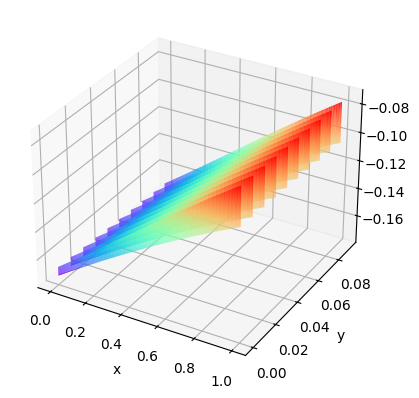

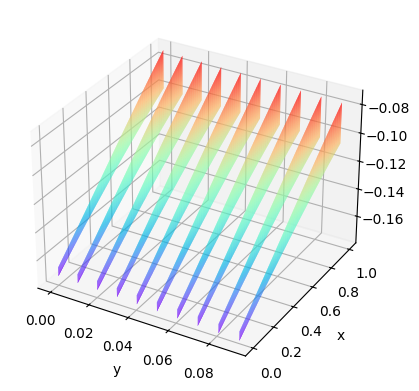

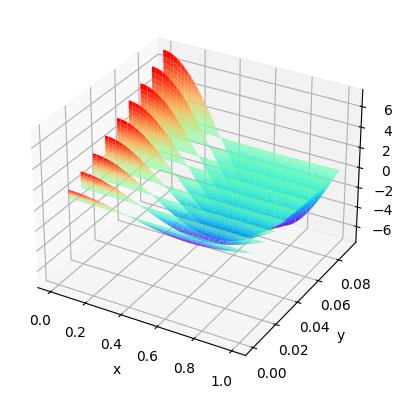

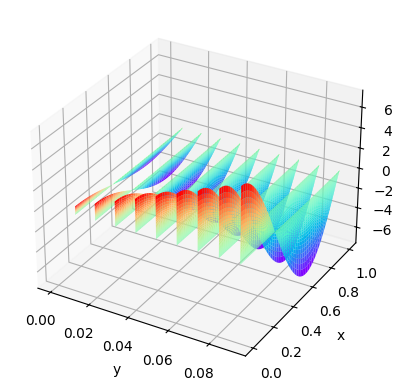

In [32]:
true_psi = analytic_solution((X, Y, T))    # (n, n)
input_X, input_Y, input_T = X.transpose(1,0).flatten()[:,None], Y.transpose(1,0).flatten()[:,None], T.transpose(1,0).flatten()[:,None]   # Both (n*n, 1)
initial_model_output = PINN.trial_eqn((input_X, input_Y, input_T))     # (n*n, 1)
initial_model_output = initial_model_output.reshape(shape=[total_points, total_points, total_points]).transpose(1,0) # Reshaped to (n,n)

plot3d(X, Y, initial_model_output)  # (n,n)(n,n)(n,n)
plot3d(X, Y, true_psi)  # (n,n)(n,n)(n,n)

# Training

In [33]:
PINN.train()
for i in range(steps):
    if i==0:
        print("Training Loss")
    loss = PINN.loss_new_appoach((X_, Y_, T_))
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()
    
    if i%(steps//20) == 0:
        print(i, loss.detach().cpu().numpy())

Training Loss
0 8.757486
250 4.938774
500 3.3207655
750 2.6095355
1000 2.4646907
1250 2.3703732
1500 2.2817562
1750 2.210894
2000 2.17333
2250 2.1567476
2500 2.1368303
2750 2.1206796
3000 2.1158514
3250 2.099896
3500 2.0506573
3750 2.0087163
4000 2.015309
4250 1.9753538
4500 1.8537165
4750 1.7904947


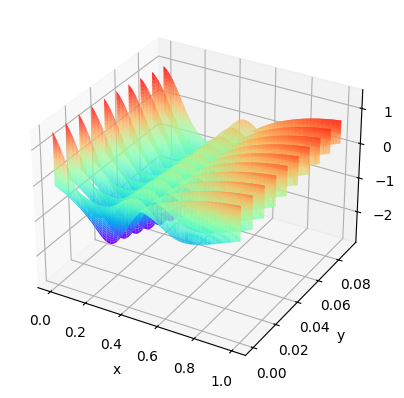

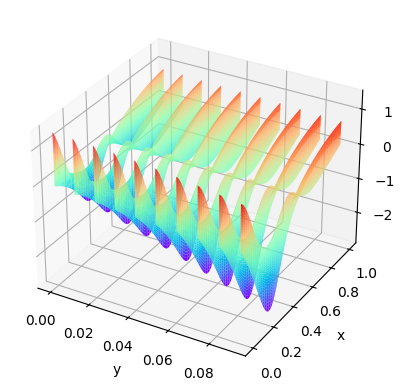

In [34]:
input_X, input_Y, input_T = X.transpose(1,0).flatten()[:,None], Y.transpose(1,0).flatten()[:,None], T.transpose(1,0).flatten()[:,None]   # Both (n*n, 1)
final_model_output = PINN.trial_eqn((input_X, input_Y, input_T)) 
final_model_output = final_model_output.reshape(shape=[total_points, total_points, total_points]).transpose(1,0) # Reshaped to (n,n)

plot3d(X, Y, final_model_output)
# plot3d(X, T, true_psi)